# TopicWeave: Comprehensive Evaluation
This notebook evaluates all TopicWeave variants including the domain-adapted version,
with hyperparameter tuning and before/after fine-tuning comparisons.

In [1]:
# Install required packages
!pip install -q numpy pandas matplotlib seaborn scikit-learn tqdm
!pip install -q umap-learn hdbscan
!pip install -q gensim tensorflow
!pip install -q sentence-transformers
!pip install -q bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from tqdm.auto import tqdm
import json
from datetime import datetime
from pathlib import Path
import random
from itertools import product
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# UMAP for dimensionality reduction
import umap

# HDBSCAN for clustering
import hdbscan

# BERTopic and sentence transformers
import bertopic
from bertopic import BERTopic

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define output and data directories
PROJECT_DIR = '/content/drive/MyDrive/MIDS/W266/final_project/'
EMBEDDING_DIR = f"{PROJECT_DIR}/embeddings/"
DOMAIN_DIR = f"{PROJECT_DIR}/domain_adaptation/"
DOMAIN_INT_DIR = f"{PROJECT_DIR}/domain_integration/"
OUTPUT_DIR = f"{PROJECT_DIR}/evaluation_results/"
FIGURE_DIR = f"{PROJECT_DIR}/figures/evaluation_results/"

# Ensure directories exist
for directory in [OUTPUT_DIR, FIGURE_DIR]:
    os.makedirs(directory, exist_ok=True)

In [4]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print(f"TopicWeave Comprehensive Evaluation - Started at {datetime.now().strftime('%Y-%m-%d %H:%M')}")

TopicWeave Comprehensive Evaluation - Started at 2025-03-30 22:18


## Data Loading

In [5]:
def load_all_embeddings():
    """
    Load all available embeddings for comprehensive evaluation
    """
    print("\n===== Loading All Embeddings =====")

    # Load document information
    docs_df = pd.read_csv(f"{EMBEDDING_DIR}/document_info.csv")

    # Dictionary to store all embeddings
    embeddings = {}

    # Load original embeddings
    embeddings["TopicWeave"] = np.load(f"{EMBEDDING_DIR}/topicweave_embeddings.npy")
    embeddings["SciBERT"] = np.load(f"{EMBEDDING_DIR}/scibert_embeddings.npy")
    embeddings["Citation"] = np.load(f"{EMBEDDING_DIR}/citation_embeddings.npy")

    # Load domain-adapted SciBERT embeddings
    domain_scibert_path = f"{DOMAIN_DIR}/domain_adapted_embeddings.npy"
    if os.path.exists(domain_scibert_path):
        embeddings["Domain-Adapted SciBERT"] = np.load(domain_scibert_path)
    else:
        print(f"Warning: Domain-adapted SciBERT embeddings not found at {domain_scibert_path}")

    # Load domain-adapted TopicWeave embeddings
    domain_topicweave_path = f"{DOMAIN_INT_DIR}/domain_topicweave_embeddings.npy"
    if os.path.exists(domain_topicweave_path):
        embeddings["Domain-Adapted TopicWeave"] = np.load(domain_topicweave_path)
    else:
        print(f"Warning: Domain-adapted TopicWeave embeddings not found at {domain_topicweave_path}")

    print("Loaded embeddings for the following models:")
    for model, embedding in embeddings.items():
        print(f"  - {model}: {embedding.shape}")

    return docs_df, embeddings

## BERTopic Model Creation and Evaluation

In [6]:
def create_custom_bertopic(embeddings, min_topic_size=10, umap_components=5,
                          umap_neighbors=15, hdbscan_min_samples=10):
    """
    Create a custom BERTopic model using pre-computed embeddings
    """
    # Create UMAP model
    umap_model = umap.UMAP(
        n_components=umap_components,
        n_neighbors=umap_neighbors,
        min_dist=0.0,
        metric='cosine',
        random_state=RANDOM_SEED
    )

    # Create HDBSCAN model
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_topic_size,
        min_samples=hdbscan_min_samples,
        metric='euclidean',
        prediction_data=True
    )

    # Create BERTopic model
    topic_model = BERTopic(
        embedding_model=None,  # No embedding model since we already have embeddings
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        verbose=True
    )

    return topic_model

In [7]:
def evaluate_bertopic_quantitative(topics, categories):
    """
    Evaluate BERTopic results using quantitative metrics
    """
    # Calculate Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(categories, topics)

    # Calculate Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(categories, topics)

    # Count unique topics and categories
    n_topics = len(set([t for t in topics if t != -1]))  # Exclude outlier topic
    n_categories = len(set(categories))

    return {
        "NMI": nmi,
        "ARI": ari,
        "n_topics": n_topics,
        "n_categories": n_categories
    }

In [8]:
def evaluate_bertopic_qualitative(topic_model, topics, texts):
    """
    Evaluate BERTopic results using qualitative metrics (coherence)
    """
    def simple_preprocess(text):
        """Simple text preprocessing for coherence calculation"""
        if isinstance(text, str):
            tokens = text.lower().split()
            return [token for token in tokens if len(token) > 2]
        return []

    # Create dictionary and corpus
    print("Building dictionary and corpus...")
    tokenized_texts = [simple_preprocess(text) for text in texts]
    dictionary = corpora.Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # Get unique topics (excluding outliers)
    unique_topics = [t for t in set(topics) if t != -1]
    print(f"Analyzing {len(unique_topics)} unique topics (excluding outliers)")

    # Get topic words
    topic_words = []
    skipped_topics = 0
    for topic_id in unique_topics:
        try:
            words = [word for word, _ in topic_model.get_topic(topic_id)][:10]
            topic_words.append(words)
        except Exception as e:
            print(f"Error getting topic words for topic {topic_id}: {e}")
            skipped_topics += 1

    print(f"Successfully extracted words for {len(topic_words)} topics (skipped {skipped_topics})")

    if not topic_words:
        print("No valid topics to analyze. Cannot calculate coherence.")
        return {"C_v Coherence": None, "NPMI Coherence": None}

    coherence_results = {}
    try:
        # Calculate C_v coherence
        cv_model = CoherenceModel(topics=topic_words, texts=tokenized_texts,
                                 dictionary=dictionary, coherence='c_v')
        coherence_results["C_v Coherence"] = cv_model.get_coherence()
    except Exception as e:
        print(f"Error calculating C_v coherence: {e}")
        coherence_results["C_v Coherence"] = None

    try:
        # Calculate NPMI coherence
        print("Calculating NPMI coherence...")
        npmi_model = CoherenceModel(topics=topic_words, texts=tokenized_texts,
                                   dictionary=dictionary, coherence='c_npmi')
        coherence_results["NPMI Coherence"] = npmi_model.get_coherence()
    except Exception as e:
        print(f"Error calculating NPMI coherence: {e}")
        coherence_results["NPMI Coherence"] = None

    return coherence_results

## Hyperparameter Tuning

In [9]:
def tune_hyperparameters_for_model(model_name, embeddings, texts, categories):
    """
    Tune hyperparameters for a specific model

    Args:
        model_name: Name of the model
        embeddings: Model embeddings
        texts: Document texts
        categories: Document categories

    Returns:
        Dictionary with tuning results
    """
    print(f"\n===== Tuning Hyperparameters for {model_name} =====")

    # Define parameter grid
    param_grid = {
        "min_topic_size": [5, 10, 15],
        "umap_components": [5, 10],
        "umap_neighbors": [10, 15, 20],
        "hdbscan_min_samples": [5, 10, 15]
    }

    results = []

    # Generate parameter combinations
    param_combinations = list(product(
        param_grid["min_topic_size"],
        param_grid["umap_components"],
        param_grid["umap_neighbors"],
        param_grid["hdbscan_min_samples"]
    ))

    print(f"Testing {len(param_combinations)} parameter combinations")

    # Test each parameter combination
    for params in tqdm(param_combinations):
        min_topic_size, umap_components, umap_neighbors, hdbscan_min_samples = params

        # Create hyperparameter dictionary
        hyperparams = {
            "min_topic_size": min_topic_size,
            "umap_components": umap_components,
            "umap_neighbors": umap_neighbors,
            "hdbscan_min_samples": hdbscan_min_samples
        }

        try:
            # Create BERTopic model
            topic_model = create_custom_bertopic(
                embeddings=embeddings,
                **hyperparams
            )

            # Fit and transform
            topics, _ = topic_model.fit_transform(texts, embeddings=embeddings)

            # Evaluate metrics
            quant_results = evaluate_bertopic_quantitative(topics, categories)
            qual_results = evaluate_bertopic_qualitative(topic_model, topics, texts)

            # Skip if coherence couldn't be calculated
            if qual_results["C_v Coherence"] is None:
                continue

            # Calculate combined score (weighted)
            # Put more weight on NMI and Coherence as they're most important for topic model quality
            combined_score = (
                0.4 * quant_results["NMI"] +
                0.2 * quant_results["ARI"] +
                0.4 * qual_results["C_v Coherence"]
            )

            # Store results
            result = {
                "min_topic_size": min_topic_size,
                "umap_components": umap_components,
                "umap_neighbors": umap_neighbors,
                "hdbscan_min_samples": hdbscan_min_samples,
                "NMI": quant_results["NMI"],
                "ARI": quant_results["ARI"],
                "n_topics": quant_results["n_topics"],
                "C_v Coherence": qual_results["C_v Coherence"],
                "NPMI Coherence": qual_results["NPMI Coherence"],
                "combined_score": combined_score
            }
            results.append(result)

        except Exception as e:
            print(f"Error with hyperparameters {hyperparams}: {e}")

    # Convert to DataFrame
    if not results:
        print(f"No valid results for {model_name}")
        return None

    results_df = pd.DataFrame(results)

    # Find best configuration
    best_idx = results_df['combined_score'].idxmax()
    best_params = {
        "min_topic_size": results_df.loc[best_idx, 'min_topic_size'],
        "umap_components": results_df.loc[best_idx, 'umap_components'],
        "umap_neighbors": results_df.loc[best_idx, 'umap_neighbors'],
        "hdbscan_min_samples": results_df.loc[best_idx, 'hdbscan_min_samples']
    }

    print(f"\nBest hyperparameters for {model_name}:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print(f"Best combined score: {results_df.loc[best_idx, 'combined_score']:.4f}")

    # Save results
    results_df.to_csv(f"{OUTPUT_DIR}/{model_name}_hyperparameter_tuning.csv", index=False)

    # Create visualization
    plt.figure(figsize=(12, 8))

    # Plot effect of each parameter on combined score
    for i, param in enumerate(param_grid.keys()):
        plt.subplot(2, 2, i+1)
        sns.boxplot(x=param, y='combined_score', data=results_df)
        plt.title(f'Effect of {param}')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{FIGURE_DIR}/{model_name}_hyperparameter_effects.png", dpi=300, bbox_inches='tight')
    plt.close()

    return {
        "best_params": best_params,
        "results_df": results_df
    }


In [10]:
def tune_hyperparameters_all_models(docs_df, embeddings_dict):
    """
    Tune hyperparameters for all models

    Args:
        docs_df: DataFrame with document data
        embeddings_dict: Dictionary with embeddings for each model

    Returns:
        Dictionary with tuning results for each model
    """
    print("\n===== Tuning Hyperparameters for All Models =====")

    texts = docs_df['processed_text'].tolist()
    categories = docs_df['category'].tolist()

    tuning_results = {}

    # Tune each model
    for model_name, embeddings in embeddings_dict.items():
        if "Domain-Adapted" in model_name:  # Focus on domain-adapted models
            print(f"\nTuning hyperparameters for {model_name}")
            model_results = tune_hyperparameters_for_model(
                model_name=model_name,
                embeddings=embeddings,
                texts=texts,
                categories=categories
            )

            if model_results:
                tuning_results[model_name] = model_results

    return tuning_results

## Run Compherensive Evaluation with Default Parameters

In [11]:
def run_default_evaluation(docs_df, embeddings_dict, hyperparams=None):
    """
    Run evaluation with default hyperparameters

    Args:
        docs_df: DataFrame with document data
        embeddings_dict: Dictionary with embeddings for each model
        hyperparams: Dictionary with hyperparameters (optional)

    Returns:
        Dictionary with evaluation results
    """
    print("\n===== Running Evaluation with Default Parameters =====")

    # Set default hyperparameters if not provided
    if hyperparams is None:
        hyperparams = {
            "min_topic_size": 10,
            "umap_components": 5,
            "umap_neighbors": 15,
            "hdbscan_min_samples": 10
        }

    # Get document texts and categories
    texts = docs_df['processed_text'].tolist()
    categories = docs_df['category'].tolist()

    # Store results
    results = {}

    # First, run the baseline model with the standard embedding approach
    print(f"\n{'='*50}")
    print(f"Running baseline BERTopic model with default embedding model")
    print(f"{'='*50}")

    try:
        # Create standard BERTopic model with default embedding model
        baseline_model = BERTopic(
            embedding_model="paraphrase-MiniLM-L12-v2",
            min_topic_size=hyperparams["min_topic_size"],
            verbose=True
        )

        # Fit and transform
        baseline_topics, baseline_probs = baseline_model.fit_transform(texts)

        # Evaluate quantitative metrics
        quant_results = evaluate_bertopic_quantitative(baseline_topics, categories)
        print("\nQuantitative Evaluation Results:")
        for metric, value in quant_results.items():
            print(f"{metric}: {value}")

        # Evaluate qualitative metrics
        qual_results = evaluate_bertopic_qualitative(baseline_model, baseline_topics, texts)
        print("\nQualitative Evaluation Results:")
        for metric, value in qual_results.items():
            if value is not None:
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: Not Calculated")

        # Store results
        results["Baseline"] = {
            "model": baseline_model,
            "topics": baseline_topics,
            "probs": baseline_probs,
            "quantitative": quant_results,
            "qualitative": qual_results,
            "description": "Standard BERTopic with paraphrase-MiniLM-L12-v2 embeddings"
        }
    except Exception as e:
        print(f"Error running baseline model: {e}")

    # Now run each embedding model
    for model_name, embeddings in embeddings_dict.items():
        print(f"\n{'='*50}")
        print(f"Running evaluation: {model_name}")
        print(f"{'='*50}")

        try:
            # Create BERTopic model
            topic_model = create_custom_bertopic(
                embeddings=embeddings,
                **hyperparams
            )

            # Fit and transform (skip the embedding step)
            topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)

            # Evaluate quantitative metrics
            quant_results = evaluate_bertopic_quantitative(topics, categories)
            print("\nQuantitative Evaluation Results:")
            for metric, value in quant_results.items():
                print(f"{metric}: {value}")

            # Evaluate qualitative metrics
            qual_results = evaluate_bertopic_qualitative(topic_model, topics, texts)
            print("\nQualitative Evaluation Results:")
            for metric, value in qual_results.items():
                if value is not None:
                    print(f"{metric}: {value:.4f}")
                else:
                    print(f"{metric}: Not Calculated")

            # Store results
            results[model_name] = {
                "model": topic_model,
                "topics": topics,
                "probs": probs,
                "quantitative": quant_results,
                "qualitative": qual_results,
                "description": f"{model_name} embeddings"
            }

        except Exception as e:
            print(f"Error in evaluating {model_name}: {e}")

    return results

## Run Evaluation with Tuned Parameters

In [12]:
def run_tuned_evaluation(docs_df, embeddings_dict, tuning_results):
    """
    Run evaluation with tuned hyperparameters

    Args:
        docs_df: DataFrame with document data
        embeddings_dict: Dictionary with embeddings for each model
        tuning_results: Dictionary with tuning results

    Returns:
        Dictionary with evaluation results
    """
    print("\n===== Running Evaluation with Tuned Parameters =====")

    # Get document texts and categories
    texts = docs_df['processed_text'].tolist()
    categories = docs_df['category'].tolist()

    # Store results
    results = {}

    # Run each tuned model
    for model_name, tuning_result in tuning_results.items():
        if model_name not in embeddings_dict:
            print(f"Skipping {model_name} - embeddings not found")
            continue

        embeddings = embeddings_dict[model_name]
        best_params = tuning_result["best_params"]

        print(f"\n{'='*50}")
        print(f"Running tuned evaluation: {model_name}")
        print(f"{'='*50}")

        try:
            # Create BERTopic model with tuned parameters
            topic_model = create_custom_bertopic(
                embeddings=embeddings,
                **best_params
            )

            # Fit and transform
            topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)

            # Evaluate quantitative metrics
            quant_results = evaluate_bertopic_quantitative(topics, categories)
            print("\nQuantitative Evaluation Results:")
            for metric, value in quant_results.items():
                print(f"{metric}: {value}")

            # Evaluate qualitative metrics
            qual_results = evaluate_bertopic_qualitative(topic_model, topics, texts)
            print("\nQualitative Evaluation Results:")
            for metric, value in qual_results.items():
                if value is not None:
                    print(f"{metric}: {value:.4f}")
                else:
                    print(f"{metric}: Not Calculated")

            # Store results
            results[f"{model_name} (Tuned)"] = {
                "model": topic_model,
                "topics": topics,
                "probs": probs,
                "quantitative": quant_results,
                "qualitative": qual_results,
                "description": f"{model_name} with tuned hyperparameters",
                "hyperparams": best_params
            }

        except Exception as e:
            print(f"Error in evaluating tuned {model_name}: {e}")

    return results

## Create Visualizations and Save Results

In [13]:
def create_comprehensive_visualizations(default_results, tuned_results=None):
    """
    Create visualizations comparing all models

    Args:
        default_results: Results with default parameters
        tuned_results: Results with tuned parameters (optional)

    Returns:
        DataFrame with summary
    """
    print("\n===== Creating Comprehensive Visualizations =====")

    # Create summary dataframe
    summary = []

    # Add default results
    for name, result in default_results.items():
        try:
            entry = {
                "Model": name,
                "Type": "Default",
                "NMI": result["quantitative"]["NMI"],
                "ARI": result["quantitative"]["ARI"],
                "Topics": result["quantitative"]["n_topics"],
                "C_v Coherence": result["qualitative"]["C_v Coherence"],
                "NPMI Coherence": result["qualitative"]["NPMI Coherence"]
            }
            summary.append(entry)
        except Exception as e:
            print(f"Error adding {name} to summary: {e}")

    # Add tuned results if available
    if tuned_results:
        for name, result in tuned_results.items():
            try:
                entry = {
                    "Model": name,
                    "Type": "Tuned",
                    "NMI": result["quantitative"]["NMI"],
                    "ARI": result["quantitative"]["ARI"],
                    "Topics": result["quantitative"]["n_topics"],
                    "C_v Coherence": result["qualitative"]["C_v Coherence"],
                    "NPMI Coherence": result["qualitative"]["NPMI Coherence"]
                }
                summary.append(entry)
            except Exception as e:
                print(f"Error adding {name} to summary: {e}")

    summary_df = pd.DataFrame(summary)

    # Create visualization comparing default and tuned models
    plt.figure(figsize=(15, 10))

    # NMI comparison
    plt.subplot(2, 2, 1)
    if tuned_results:
        sns.barplot(x="Model", y="NMI", hue="Type", data=summary_df)
    else:
        sns.barplot(x="Model", y="NMI", data=summary_df)
    plt.title('NMI Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')

    # ARI comparison
    plt.subplot(2, 2, 2)
    if tuned_results:
        sns.barplot(x="Model", y="ARI", hue="Type", data=summary_df)
    else:
        sns.barplot(x="Model", y="ARI", data=summary_df)
    plt.title('ARI Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')

    # C_v Coherence comparison
    plt.subplot(2, 2, 3)
    if tuned_results:
        sns.barplot(x="Model", y="C_v Coherence", hue="Type", data=summary_df)
    else:
        sns.barplot(x="Model", y="C_v Coherence", data=summary_df)
    plt.title('C_v Coherence Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')

    # Topics count comparison
    plt.subplot(2, 2, 4)
    if tuned_results:
        sns.barplot(x="Model", y="Topics", hue="Type", data=summary_df)
    else:
        sns.barplot(x="Model", y="Topics", data=summary_df)
    plt.title('Number of Topics Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig(f"{FIGURE_DIR}/model_comparison.png", dpi=300, bbox_inches='tight')

    # Create radar chart for comparing models
    plt.figure(figsize=(12, 10))

    # Prepare the data
    metrics = ['NMI', 'ARI', 'C_v Coherence', 'NPMI Coherence']

    # Number of variables
    N = len(metrics)

    # Create angle array for radar chart
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Create polar plot
    ax = plt.subplot(111, polar=True)

    # Focus on key models
    key_models = ["Baseline", "TopicWeave", "Domain-Adapted SciBERT", "Domain-Adapted TopicWeave"]

    # For each model
    for model in key_models:
        if model in default_results:
            values = [
                default_results[model]["quantitative"]["NMI"],
                default_results[model]["quantitative"]["ARI"],
                default_results[model]["qualitative"]["C_v Coherence"] if default_results[model]["qualitative"]["C_v Coherence"] else 0,
                default_results[model]["qualitative"]["NPMI Coherence"] if default_results[model]["qualitative"]["NPMI Coherence"] else 0
            ]
            values += values[:1]  # Close the loop

            # Plot the model
            ax.plot(angles, values, linewidth=2, label=model)
            ax.fill(angles, values, alpha=0.1)

    # Add tuned models to the radar chart
    if tuned_results:
        for model_name in tuned_results:
            base_name = model_name.replace(" (Tuned)", "")
            if base_name in key_models:
                values = [
                    tuned_results[model_name]["quantitative"]["NMI"],
                    tuned_results[model_name]["quantitative"]["ARI"],
                    tuned_results[model_name]["qualitative"]["C_v Coherence"] if tuned_results[model_name]["qualitative"]["C_v Coherence"] else 0,
                    tuned_results[model_name]["qualitative"]["NPMI Coherence"] if tuned_results[model_name]["qualitative"]["NPMI Coherence"] else 0
                ]
                values += values[:1]  # Close the loop

                # Plot the tuned model
                ax.plot(angles, values, linewidth=2, label=f"{base_name} (Tuned)", linestyle='--')
                ax.fill(angles, values, alpha=0.1)

    # Set labels and title
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title('Model Comparison across Metrics', size=15)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.savefig(f"{FIGURE_DIR}/radar_chart.png", dpi=300, bbox_inches='tight')
    plt.close()

    return summary_df

In [22]:
def save_comprehensive_results(default_results, summary_df, domain_df, tuned_results=None):
    """
    Save comprehensive evaluation results

    Args:
        default_results: Results with default parameters
        summary_df: Summary DataFrame
        domain_df: Domain-specific analysis DataFrame
        tuned_results: Results with tuned parameters (optional)
    """
    print("\n===== Saving Comprehensive Results =====")

    # Save summary table
    summary_df.to_csv(f"{OUTPUT_DIR}/comprehensive_evaluation.csv", index=False)

    # Save domain-specific analysis if available
    if domain_df is not None:
        domain_df.to_csv(f"{OUTPUT_DIR}/domain_specific_analysis.csv", index=False)

    # Save topic information for each model with default parameters
    for name, result in default_results.items():
        try:
            model = result["model"]
            topic_info = model.get_topic_info()
            topic_info.to_csv(f"{OUTPUT_DIR}/{name}_topic_info.csv", index=False)

            # Save top terms for each topic
            topics_dict = {}
            for topic_id in topic_info['Topic']:
                if topic_id != -1:  # Skip outlier topic
                    topics_dict[topic_id] = model.get_topic(topic_id)

            # Save topic terms as JSON
            with open(f"{OUTPUT_DIR}/{name}_topic_terms.json", 'w') as f:
                json.dump({str(k): [(str(w), float(s)) for w, s in v] for k, v in topics_dict.items()}, f, indent=2)

            # Save hyperparameters if this is a tuned model
            if "hyperparams" in result:
                with open(f"{OUTPUT_DIR}/{name}_hyperparams.json", 'w') as f:
                    json.dump(result["hyperparams"], f, indent=2)
        except Exception as e:
            print(f"Error saving topic info for {name}: {e}")

    # Helper function to make results JSON serializable
        def convert_to_serializable(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            else:
                return obj

    # Save tuned results if available
    if tuned_results:
        for name, result in tuned_results.items():
            try:
                model = result["model"]
                topic_info = model.get_topic_info()
                topic_info.to_csv(f"{OUTPUT_DIR}/{name}_topic_info.csv", index=False)

                # Convert hyperparameters to serializable format
                if "hyperparams" in result:
                    serializable_hyperparams = {k: convert_to_serializable(v) for k, v in result["hyperparams"].items()}
                    with open(f"{OUTPUT_DIR}/{name}_hyperparams.json", 'w') as f:
                        json.dump(serializable_hyperparams, f, indent=2)

                # Save topic terms
                topics_dict = {}
                for topic_id in topic_info['Topic']:
                    if topic_id != -1:  # Skip outlier topic
                        topics_dict[topic_id] = model.get_topic(topic_id)

                # Save topic terms as JSON for tuned models
                with open(f"{OUTPUT_DIR}/{name}_topic_terms.json", 'w') as f:
                    json.dump({str(convert_to_serializable(k)): [(str(w), float(s)) for w, s in v]
                              for k, v in topics_dict.items()}, f, indent=2)
            except Exception as e:
                print(f"Error saving tuned results for {name}: {e}")

    print(f"Results saved to {OUTPUT_DIR}")

In [15]:
def create_domain_specific_analysis(default_results, tuned_results=None):
    """
    Create domain-specific analysis comparing performance across domains

    Args:
        default_results: Results with default parameters
        tuned_results: Results with tuned parameters (optional)

    Returns:
        DataFrame with domain-specific analysis
    """
    print("\n===== Creating Domain-Specific Analysis =====")

    # All domains used for fine-tuning
    target_domains = ["cs.AI", "cs.CL", "cs.CV", "cs.DL", "cs.LG", "math.ST",
                      "physics.comp-ph", "q-bio.QM", "q-fin.ST", "stat.ML"]

    # Extract topics and categories
    domain_analysis = []

    # Get all documents by domain
    docs_df = pd.read_csv(f"{EMBEDDING_DIR}/document_info.csv")

    # Process default results
    for model_name, result in default_results.items():
        if "model" not in result or "topics" not in result:
            continue

        topics = result["topics"]

        # For each domain
        for domain in target_domains:
            # Get documents for this domain
            domain_indices = docs_df[docs_df['category'] == domain].index.tolist()

            if domain_indices:
                # Get topic assignments for this domain
                domain_topics = [topics[i] for i in domain_indices if i < len(topics)]
                domain_categories = [domain] * len(domain_topics)

                # Calculate metrics
                try:
                    nmi = normalized_mutual_info_score(domain_categories, domain_topics)
                    ari = adjusted_rand_score(domain_categories, domain_topics)

                    domain_analysis.append({
                        "Model": model_name,
                        "Type": "Default",
                        "Domain": domain,
                        "NMI": nmi,
                        "ARI": ari,
                        "Document Count": len(domain_indices)
                    })
                except Exception as e:
                    print(f"Error calculating metrics for {model_name} on {domain}: {e}")

    # Process tuned results if available
    if tuned_results:
        for model_name, result in tuned_results.items():
            if "model" not in result or "topics" not in result:
                continue

            topics = result["topics"]

            # For each domain
            for domain in target_domains:
                # Get documents for this domain
                domain_indices = docs_df[docs_df['category'] == domain].index.tolist()

                if domain_indices:
                    # Get topic assignments for this domain
                    domain_topics = [topics[i] for i in domain_indices if i < len(topics)]
                    domain_categories = [domain] * len(domain_topics)

                    # Calculate metrics
                    try:
                        nmi = normalized_mutual_info_score(domain_categories, domain_topics)
                        ari = adjusted_rand_score(domain_categories, domain_topics)

                        domain_analysis.append({
                            "Model": model_name,
                            "Type": "Tuned",
                            "Domain": domain,
                            "NMI": nmi,
                            "ARI": ari,
                            "Document Count": len(domain_indices)
                        })
                    except Exception as e:
                        print(f"Error calculating metrics for {model_name} on {domain}: {e}")

    # Convert to DataFrame
    domain_df = pd.DataFrame(domain_analysis)

    if len(domain_df) == 0:
        print("No domain-specific analysis created - empty results")
        return domain_df

    # Save domain analysis
    domain_df.to_csv(f"{OUTPUT_DIR}/domain_specific_analysis.csv", index=False)

    # Create heatmap of model performance by domain
    plt.figure(figsize=(14, 10))

    # Filter to key models for more readable visualization
    key_models = ["Baseline", "TopicWeave", "Domain-Adapted SciBERT", "Domain-Adapted TopicWeave"]
    if tuned_results:
        for model in key_models:
            if f"{model} (Tuned)" in tuned_results:
                key_models.append(f"{model} (Tuned)")

    # Filter dataframe
    plot_df = domain_df[domain_df['Model'].isin(key_models)]

    # Create pivot table for NMI scores
    heatmap_data = plot_df.pivot_table(index='Model', columns='Domain', values='NMI')

    # Create heatmap
    ax = sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f", linewidths=0.5)
    plt.title("NMI Scores by Model and Domain")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{FIGURE_DIR}/domain_performance_heatmap.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Create improvement visualization if tuned results available
    if tuned_results:
        improvement_data = []
        for model in key_models:
            if model in default_results and f"{model} (Tuned)" in tuned_results:
                # For each domain
                for domain in target_domains:
                    default_nmi = plot_df[(plot_df['Model'] == model) &
                                          (plot_df['Domain'] == domain)]['NMI'].values
                    tuned_nmi = plot_df[(plot_df['Model'] == f"{model} (Tuned)") &
                                        (plot_df['Domain'] == domain)]['NMI'].values

                    if len(default_nmi) > 0 and len(tuned_nmi) > 0:
                        improvement = float(tuned_nmi[0]) - float(default_nmi[0])
                        improvement_data.append({
                            "Model": model,
                            "Domain": domain,
                            "Improvement": improvement,
                            "Improvement %": improvement / float(default_nmi[0]) * 100 if float(default_nmi[0]) != 0 else 0
                        })

        if improvement_data:
            # Create improvement dataframe
            imp_df = pd.DataFrame(improvement_data)

            # Create heatmap of improvements
            plt.figure(figsize=(14, 10))
            imp_pivot = imp_df.pivot_table(index='Model', columns='Domain', values='Improvement')
            sns.heatmap(imp_pivot, annot=True, cmap="RdYlGn", fmt=".3f", center=0, linewidths=0.5)
            plt.title("NMI Improvement from Hyperparameter Tuning by Domain")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(f"{FIGURE_DIR}/tuning_improvement_heatmap.png", dpi=300, bbox_inches='tight')
            plt.close()

    return domain_df

## Main Execution

In [16]:
start_time = datetime.now()

# Step 1: Load all embeddings
docs_df, embeddings_dict = load_all_embeddings()


===== Loading All Embeddings =====
Loaded embeddings for the following models:
  - TopicWeave: (45655, 768)
  - SciBERT: (45655, 768)
  - Citation: (45655, 768)
  - Domain-Adapted SciBERT: (45655, 768)
  - Domain-Adapted TopicWeave: (45655, 768)


In [17]:
# Step 2: Run default evaluation
print("\n[Step 2]: Running evaluation with default parameters")
default_results = run_default_evaluation(docs_df, embeddings_dict)

2025-03-30 22:19:08,084 - BERTopic - Embedding - Transforming documents to embeddings.



[Step 2]: Running evaluation with default parameters

===== Running Evaluation with Default Parameters =====

Running baseline BERTopic model with default embedding model


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1427 [00:00<?, ?it/s]

2025-03-30 22:20:00,855 - BERTopic - Embedding - Completed ✓
2025-03-30 22:20:00,856 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:20:37,274 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:20:37,276 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:20:40,856 - BERTopic - Cluster - Completed ✓
2025-03-30 22:20:40,877 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:20:44,290 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.2942962802150318
ARI: 0.02516090540233512
n_topics: 364
n_categories: 10
Building dictionary and corpus...
Analyzing 364 unique topics (excluding outliers)
Successfully extracted words for 364 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:22:06,647 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Qualitative Evaluation Results:
C_v Coherence: 0.5788
NPMI Coherence: 0.0989

Running evaluation: TopicWeave


2025-03-30 22:23:03,000 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:23:03,002 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:23:05,006 - BERTopic - Cluster - Completed ✓
2025-03-30 22:23:05,018 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:23:09,219 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.335306882303558
ARI: 0.030723056384189866
n_topics: 370
n_categories: 10
Building dictionary and corpus...
Analyzing 370 unique topics (excluding outliers)
Successfully extracted words for 370 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:24:16,804 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Qualitative Evaluation Results:
C_v Coherence: 0.6000
NPMI Coherence: 0.1026

Running evaluation: SciBERT


2025-03-30 22:25:12,313 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:25:12,315 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:25:14,348 - BERTopic - Cluster - Completed ✓
2025-03-30 22:25:14,358 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:25:18,262 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.16203598222279333
ARI: 0.010627533581384548
n_topics: 53
n_categories: 10
Building dictionary and corpus...
Analyzing 53 unique topics (excluding outliers)
Successfully extracted words for 53 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:25:49,327 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Qualitative Evaluation Results:
C_v Coherence: 0.6195
NPMI Coherence: 0.1104

Running evaluation: Citation


2025-03-30 22:26:46,980 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:26:46,982 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:26:48,962 - BERTopic - Cluster - Completed ✓
2025-03-30 22:26:48,975 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:26:53,213 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.33492775997965296
ARI: 0.03738078092359722
n_topics: 380
n_categories: 10
Building dictionary and corpus...
Analyzing 380 unique topics (excluding outliers)
Successfully extracted words for 380 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:28:13,338 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Qualitative Evaluation Results:
C_v Coherence: 0.5884
NPMI Coherence: 0.0992

Running evaluation: Domain-Adapted SciBERT


2025-03-30 22:29:08,507 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:29:08,509 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:29:10,689 - BERTopic - Cluster - Completed ✓
2025-03-30 22:29:10,701 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:29:14,831 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.31562144403223347
ARI: 0.027517050020383932
n_topics: 315
n_categories: 10
Building dictionary and corpus...
Analyzing 315 unique topics (excluding outliers)
Successfully extracted words for 315 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:30:29,471 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Qualitative Evaluation Results:
C_v Coherence: 0.5922
NPMI Coherence: 0.1100

Running evaluation: Domain-Adapted TopicWeave


2025-03-30 22:31:25,269 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:31:25,271 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:31:27,324 - BERTopic - Cluster - Completed ✓
2025-03-30 22:31:27,336 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:31:31,549 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.35759476084211494
ARI: 0.06715870438731443
n_topics: 301
n_categories: 10
Building dictionary and corpus...
Analyzing 301 unique topics (excluding outliers)
Successfully extracted words for 301 topics (skipped 0)
Calculating NPMI coherence...

Qualitative Evaluation Results:
C_v Coherence: 0.6040
NPMI Coherence: 0.1135


In [18]:
# Step 3: Run hyperparameter tuning (optional)
run_tuning = True  # Set to False to skip tuning
if run_tuning:
    print("\n[Step 3]: Tuning hyperparameters for domain-adapted models")
    # Only tune the domain-adapted models to save time
    tuning_models = {k: v for k, v in embeddings_dict.items() if "Domain-Adapted" in k}
    tuning_results = tune_hyperparameters_all_models(docs_df, tuning_models)

    # Step 4: Run evaluation with tuned parameters
    print("\n[Step 4]: Running evaluation with tuned parameters")
    tuned_results = run_tuned_evaluation(docs_df, embeddings_dict, tuning_results)
else:
    tuning_results = None
    tuned_results = None


[Step 3]: Tuning hyperparameters for domain-adapted models

===== Tuning Hyperparameters for All Models =====

Tuning hyperparameters for Domain-Adapted SciBERT

===== Tuning Hyperparameters for Domain-Adapted SciBERT =====
Testing 54 parameter combinations


  0%|          | 0/54 [00:00<?, ?it/s]

2025-03-30 22:32:39,658 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:33:27,772 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:33:27,774 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:33:30,489 - BERTopic - Cluster - Completed ✓
2025-03-30 22:33:30,504 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:33:35,378 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 1008 unique topics (excluding outliers)
Successfully extracted words for 1008 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:38:22,968 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:39:07,739 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:39:07,741 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:39:11,595 - BERTopic - Cluster - Completed ✓
2025-03-30 22:39:11,609 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:39:16,137 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 502 unique topics (excluding outliers)
Successfully extracted words for 502 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:40:52,902 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:41:37,845 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:41:37,847 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:41:39,995 - BERTopic - Cluster - Completed ✓
2025-03-30 22:41:40,007 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:41:44,221 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 307 unique topics (excluding outliers)
Successfully extracted words for 307 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:42:56,695 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:43:52,325 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:43:52,327 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:43:55,040 - BERTopic - Cluster - Completed ✓
2025-03-30 22:43:55,055 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:43:59,741 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 814 unique topics (excluding outliers)
Successfully extracted words for 814 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:47:26,542 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:48:22,598 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:48:22,599 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:48:24,911 - BERTopic - Cluster - Completed ✓
2025-03-30 22:48:24,923 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:48:29,249 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 393 unique topics (excluding outliers)
Successfully extracted words for 393 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:49:56,334 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:50:51,844 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:50:51,846 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:50:54,105 - BERTopic - Cluster - Completed ✓
2025-03-30 22:50:54,117 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:50:58,382 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 285 unique topics (excluding outliers)
Successfully extracted words for 285 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:52:06,844 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:53:11,998 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:53:11,999 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:53:14,612 - BERTopic - Cluster - Completed ✓
2025-03-30 22:53:14,627 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:53:19,310 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 751 unique topics (excluding outliers)
Successfully extracted words for 751 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:55:46,518 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:56:53,169 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:56:53,171 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:56:55,387 - BERTopic - Cluster - Completed ✓
2025-03-30 22:56:55,399 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:56:59,653 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 301 unique topics (excluding outliers)
Successfully extracted words for 301 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 22:58:09,039 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 22:59:13,732 - BERTopic - Dimensionality - Completed ✓
2025-03-30 22:59:13,733 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 22:59:15,928 - BERTopic - Cluster - Completed ✓
2025-03-30 22:59:15,939 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 22:59:20,190 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 250 unique topics (excluding outliers)
Successfully extracted words for 250 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:00:21,457 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:01:16,366 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:01:16,369 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:01:21,001 - BERTopic - Cluster - Completed ✓
2025-03-30 23:01:21,017 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:01:25,929 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 997 unique topics (excluding outliers)
Successfully extracted words for 997 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:06:15,126 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:07:08,988 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:07:08,990 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:07:14,903 - BERTopic - Cluster - Completed ✓
2025-03-30 23:07:14,916 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:07:19,506 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 459 unique topics (excluding outliers)
Successfully extracted words for 459 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:08:55,152 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:09:49,226 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:09:49,229 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:09:53,574 - BERTopic - Cluster - Completed ✓
2025-03-30 23:09:53,586 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:09:57,841 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 293 unique topics (excluding outliers)
Successfully extracted words for 293 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:11:08,746 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:12:15,496 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:12:15,498 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:12:20,078 - BERTopic - Cluster - Completed ✓
2025-03-30 23:12:20,092 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:12:24,896 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 862 unique topics (excluding outliers)
Successfully extracted words for 862 topics (skipped 0)
Calculating NPMI coherence...


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-03-30 23:16:10,447 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:17:17,501 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:17:17,504 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:17:23,489 - BERTopic - Cluster - Completed ✓
2025-03-30 23:17:23,502 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:17:28,031 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 392 unique topics (excluding outliers)
Successfully extracted words for 392 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:18:53,341 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:20:00,099 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:20:00,101 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:20:04,478 - BERTopic - Cluster - Completed ✓
2025-03-30 23:20:04,489 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:20:08,735 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 241 unique topics (excluding outliers)
Successfully extracted words for 241 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:21:11,330 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:22:29,135 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:22:29,137 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:22:34,702 - BERTopic - Cluster - Completed ✓
2025-03-30 23:22:34,717 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:22:39,422 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 759 unique topics (excluding outliers)
Successfully extracted words for 759 topics (skipped 0)
Calculating NPMI coherence...


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-03-30 23:25:05,296 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:26:23,720 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:26:23,723 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:26:29,092 - BERTopic - Cluster - Completed ✓
2025-03-30 23:26:29,104 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:26:33,477 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 333 unique topics (excluding outliers)
Successfully extracted words for 333 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:27:48,302 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:29:07,703 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:29:07,706 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:29:13,229 - BERTopic - Cluster - Completed ✓
2025-03-30 23:29:13,240 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:29:17,541 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 235 unique topics (excluding outliers)
Successfully extracted words for 235 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:30:18,421 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:31:02,767 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:31:02,769 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:31:04,977 - BERTopic - Cluster - Completed ✓
2025-03-30 23:31:04,991 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:31:09,455 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 496 unique topics (excluding outliers)
Successfully extracted words for 496 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:32:52,216 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:33:36,867 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:33:36,869 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:33:38,965 - BERTopic - Cluster - Completed ✓
2025-03-30 23:33:38,978 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:33:43,341 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 368 unique topics (excluding outliers)
Successfully extracted words for 368 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:35:00,491 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:35:45,700 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:35:45,701 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:35:47,785 - BERTopic - Cluster - Completed ✓
2025-03-30 23:35:47,797 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:35:51,993 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 242 unique topics (excluding outliers)
Successfully extracted words for 242 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:36:54,990 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:37:49,771 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:37:49,773 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:37:52,039 - BERTopic - Cluster - Completed ✓
2025-03-30 23:37:52,053 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:37:56,464 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 455 unique topics (excluding outliers)
Successfully extracted words for 455 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:39:32,065 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:40:28,200 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:40:28,202 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:40:30,383 - BERTopic - Cluster - Completed ✓
2025-03-30 23:40:30,394 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:40:34,687 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 315 unique topics (excluding outliers)
Successfully extracted words for 315 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:41:50,060 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:42:45,055 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:42:45,057 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:42:47,322 - BERTopic - Cluster - Completed ✓
2025-03-30 23:42:47,334 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:42:51,560 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 179 unique topics (excluding outliers)
Successfully extracted words for 179 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:43:44,757 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:44:50,107 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:44:50,109 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:44:52,340 - BERTopic - Cluster - Completed ✓
2025-03-30 23:44:52,352 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:44:56,754 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 366 unique topics (excluding outliers)
Successfully extracted words for 366 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:46:14,268 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:47:18,928 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:47:18,930 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:47:21,113 - BERTopic - Cluster - Completed ✓
2025-03-30 23:47:21,125 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:47:25,481 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 250 unique topics (excluding outliers)
Successfully extracted words for 250 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:48:27,024 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:49:31,556 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:49:31,558 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:49:33,705 - BERTopic - Cluster - Completed ✓
2025-03-30 23:49:33,716 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:49:37,948 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 212 unique topics (excluding outliers)
Successfully extracted words for 212 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:50:37,715 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:51:32,509 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:51:32,512 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:51:36,711 - BERTopic - Cluster - Completed ✓
2025-03-30 23:51:36,725 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:51:41,273 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 541 unique topics (excluding outliers)
Successfully extracted words for 541 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:53:34,646 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:54:30,769 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:54:30,772 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:54:35,039 - BERTopic - Cluster - Completed ✓
2025-03-30 23:54:35,052 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:54:39,424 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 361 unique topics (excluding outliers)
Successfully extracted words for 361 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:55:57,973 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:56:52,557 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:56:52,560 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:56:56,842 - BERTopic - Cluster - Completed ✓
2025-03-30 23:56:56,853 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:57:01,101 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 255 unique topics (excluding outliers)
Successfully extracted words for 255 topics (skipped 0)
Calculating NPMI coherence...


2025-03-30 23:58:05,355 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-30 23:59:12,375 - BERTopic - Dimensionality - Completed ✓
2025-03-30 23:59:12,378 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-30 23:59:16,632 - BERTopic - Cluster - Completed ✓
2025-03-30 23:59:16,645 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-30 23:59:21,110 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 462 unique topics (excluding outliers)
Successfully extracted words for 462 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:01:02,587 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:02:09,329 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:02:09,332 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:02:13,572 - BERTopic - Cluster - Completed ✓
2025-03-31 00:02:13,584 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:02:17,908 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 308 unique topics (excluding outliers)
Successfully extracted words for 308 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:03:31,143 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:04:38,408 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:04:38,410 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:04:42,760 - BERTopic - Cluster - Completed ✓
2025-03-31 00:04:42,771 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:04:46,994 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 212 unique topics (excluding outliers)
Successfully extracted words for 212 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:05:46,362 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:07:04,178 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:07:04,181 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:07:09,368 - BERTopic - Cluster - Completed ✓
2025-03-31 00:07:09,381 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:07:13,900 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 427 unique topics (excluding outliers)
Successfully extracted words for 427 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:08:45,041 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:10:04,986 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:10:04,989 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:10:10,242 - BERTopic - Cluster - Completed ✓
2025-03-31 00:10:10,253 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:10:14,545 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 264 unique topics (excluding outliers)
Successfully extracted words for 264 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:11:19,645 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:12:37,637 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:12:37,639 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:12:43,154 - BERTopic - Cluster - Completed ✓
2025-03-31 00:12:43,165 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:12:47,387 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 207 unique topics (excluding outliers)
Successfully extracted words for 207 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:13:46,231 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:14:30,629 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:14:30,631 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:14:32,706 - BERTopic - Cluster - Completed ✓
2025-03-31 00:14:32,720 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:14:37,097 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 344 unique topics (excluding outliers)
Successfully extracted words for 344 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:15:53,521 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:16:38,368 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:16:38,369 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:16:40,385 - BERTopic - Cluster - Completed ✓
2025-03-31 00:16:40,397 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:16:44,634 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 248 unique topics (excluding outliers)
Successfully extracted words for 248 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:17:48,267 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:18:32,904 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:18:32,905 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:18:34,985 - BERTopic - Cluster - Completed ✓
2025-03-31 00:18:34,997 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:18:39,220 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 233 unique topics (excluding outliers)
Successfully extracted words for 233 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:19:41,386 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:20:36,426 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:20:36,428 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:20:38,564 - BERTopic - Cluster - Completed ✓
2025-03-31 00:20:38,576 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:20:42,880 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 323 unique topics (excluding outliers)
Successfully extracted words for 323 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:21:58,005 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:22:53,009 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:22:53,011 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:22:55,173 - BERTopic - Cluster - Completed ✓
2025-03-31 00:22:55,184 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:22:59,445 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 260 unique topics (excluding outliers)
Successfully extracted words for 260 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:24:05,161 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:25:00,254 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:25:00,257 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:25:02,414 - BERTopic - Cluster - Completed ✓
2025-03-31 00:25:02,425 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:25:06,606 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 159 unique topics (excluding outliers)
Successfully extracted words for 159 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:25:57,522 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:27:03,913 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:27:03,914 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:27:06,029 - BERTopic - Cluster - Completed ✓
2025-03-31 00:27:06,040 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:27:10,310 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 249 unique topics (excluding outliers)
Successfully extracted words for 249 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:28:14,235 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:29:19,204 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:29:19,206 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:29:21,323 - BERTopic - Cluster - Completed ✓
2025-03-31 00:29:21,334 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:29:25,529 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 197 unique topics (excluding outliers)
Successfully extracted words for 197 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:30:22,972 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:31:28,104 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:31:28,106 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:31:30,229 - BERTopic - Cluster - Completed ✓
2025-03-31 00:31:30,240 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:31:34,464 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 187 unique topics (excluding outliers)
Successfully extracted words for 187 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:32:31,573 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:33:27,498 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:33:27,501 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:33:31,542 - BERTopic - Cluster - Completed ✓
2025-03-31 00:33:31,555 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:33:35,851 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 351 unique topics (excluding outliers)
Successfully extracted words for 351 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:34:54,461 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:35:49,291 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:35:49,294 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:35:53,424 - BERTopic - Cluster - Completed ✓
2025-03-31 00:35:53,435 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:35:57,716 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 284 unique topics (excluding outliers)
Successfully extracted words for 284 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:37:08,544 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:38:03,316 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:38:03,319 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:38:07,583 - BERTopic - Cluster - Completed ✓
2025-03-31 00:38:07,594 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:38:11,796 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 219 unique topics (excluding outliers)
Successfully extracted words for 219 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:39:14,068 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:40:20,013 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:40:20,015 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:40:24,138 - BERTopic - Cluster - Completed ✓
2025-03-31 00:40:24,150 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:40:28,492 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 311 unique topics (excluding outliers)
Successfully extracted words for 311 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:41:43,408 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:42:50,672 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:42:50,675 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:42:54,828 - BERTopic - Cluster - Completed ✓
2025-03-31 00:42:54,839 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:42:59,083 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 223 unique topics (excluding outliers)
Successfully extracted words for 223 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:44:02,038 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:45:09,213 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:45:09,215 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:45:13,530 - BERTopic - Cluster - Completed ✓
2025-03-31 00:45:13,541 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:45:17,740 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 188 unique topics (excluding outliers)
Successfully extracted words for 188 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:46:13,704 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:47:30,818 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:47:30,821 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:47:35,821 - BERTopic - Cluster - Completed ✓
2025-03-31 00:47:35,832 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:47:40,113 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 242 unique topics (excluding outliers)
Successfully extracted words for 242 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:48:42,589 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:50:00,863 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:50:00,866 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:50:06,092 - BERTopic - Cluster - Completed ✓
2025-03-31 00:50:06,103 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:50:10,357 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 224 unique topics (excluding outliers)
Successfully extracted words for 224 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 00:51:11,561 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:52:29,385 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:52:29,388 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:52:34,852 - BERTopic - Cluster - Completed ✓
2025-03-31 00:52:34,864 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:52:39,057 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 165 unique topics (excluding outliers)
Successfully extracted words for 165 topics (skipped 0)
Calculating NPMI coherence...

Best hyperparameters for Domain-Adapted SciBERT:
  min_topic_size: 15
  umap_components: 10
  umap_neighbors: 20
  hdbscan_min_samples: 15
Best combined score: 0.4403

Tuning hyperparameters for Domain-Adapted TopicWeave

===== Tuning Hyperparameters for Domain-Adapted TopicWeave =====
Testing 54 parameter combinations


  0%|          | 0/54 [00:00<?, ?it/s]

2025-03-31 00:53:33,271 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:54:17,636 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:54:17,637 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:54:20,274 - BERTopic - Cluster - Completed ✓
2025-03-31 00:54:20,289 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:54:25,307 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 1022 unique topics (excluding outliers)
Successfully extracted words for 1022 topics (skipped 0)
Calculating NPMI coherence...


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-03-31 00:59:43,259 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:00:28,391 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:00:28,393 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:00:32,260 - BERTopic - Cluster - Completed ✓
2025-03-31 01:00:32,274 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:00:36,917 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 506 unique topics (excluding outliers)
Successfully extracted words for 506 topics (skipped 0)
Calculating NPMI coherence...


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-03-31 01:02:20,228 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:03:06,026 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:03:06,028 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:03:08,133 - BERTopic - Cluster - Completed ✓
2025-03-31 01:03:08,146 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:03:12,769 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 341 unique topics (excluding outliers)
Successfully extracted words for 341 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:04:28,240 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:05:23,610 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:05:23,612 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:05:26,179 - BERTopic - Cluster - Completed ✓
2025-03-31 01:05:26,195 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:05:31,092 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 915 unique topics (excluding outliers)
Successfully extracted words for 915 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:09:42,792 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:10:38,257 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:10:38,259 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:10:42,092 - BERTopic - Cluster - Completed ✓
2025-03-31 01:10:42,105 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:10:46,692 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 376 unique topics (excluding outliers)
Successfully extracted words for 376 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:11:59,512 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:12:55,293 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:12:55,295 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:12:57,448 - BERTopic - Cluster - Completed ✓
2025-03-31 01:12:57,460 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:13:01,811 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 271 unique topics (excluding outliers)
Successfully extracted words for 271 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:14:08,347 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:15:14,381 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:15:14,383 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:15:16,909 - BERTopic - Cluster - Completed ✓
2025-03-31 01:15:16,924 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:15:21,741 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 813 unique topics (excluding outliers)
Successfully extracted words for 813 topics (skipped 0)
Calculating NPMI coherence...


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-03-31 01:18:55,717 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:20:00,929 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:20:00,931 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:20:03,115 - BERTopic - Cluster - Completed ✓
2025-03-31 01:20:03,128 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:20:07,542 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 348 unique topics (excluding outliers)
Successfully extracted words for 348 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:21:21,560 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:22:26,882 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:22:26,883 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:22:29,039 - BERTopic - Cluster - Completed ✓
2025-03-31 01:22:29,051 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:22:33,472 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 265 unique topics (excluding outliers)
Successfully extracted words for 265 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:23:39,427 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:24:35,536 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:24:35,538 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:24:39,791 - BERTopic - Cluster - Completed ✓
2025-03-31 01:24:39,807 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:24:44,826 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 1049 unique topics (excluding outliers)
Successfully extracted words for 1049 topics (skipped 0)
Calculating NPMI coherence...


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-03-31 01:30:10,546 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:31:05,869 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:31:05,871 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:31:11,448 - BERTopic - Cluster - Completed ✓
2025-03-31 01:31:11,462 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:31:16,148 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 536 unique topics (excluding outliers)
Successfully extracted words for 536 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:33:08,783 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:34:03,297 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:34:03,300 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:34:07,169 - BERTopic - Cluster - Completed ✓
2025-03-31 01:34:07,181 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:34:11,534 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 289 unique topics (excluding outliers)
Successfully extracted words for 289 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:35:21,336 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:36:28,656 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:36:28,659 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:36:32,369 - BERTopic - Cluster - Completed ✓
2025-03-31 01:36:32,385 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:36:37,258 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 840 unique topics (excluding outliers)
Successfully extracted words for 840 topics (skipped 0)
Calculating NPMI coherence...


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-03-31 01:40:20,415 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:41:27,685 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:41:27,689 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:41:31,142 - BERTopic - Cluster - Completed ✓
2025-03-31 01:41:31,156 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:41:35,710 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 450 unique topics (excluding outliers)
Successfully extracted words for 450 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:43:12,818 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:44:20,341 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:44:20,343 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:44:23,797 - BERTopic - Cluster - Completed ✓
2025-03-31 01:44:23,809 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:44:28,159 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 273 unique topics (excluding outliers)
Successfully extracted words for 273 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:45:36,393 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:46:54,947 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:46:54,949 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:46:58,780 - BERTopic - Cluster - Completed ✓
2025-03-31 01:46:58,796 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:47:03,597 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 759 unique topics (excluding outliers)
Successfully extracted words for 759 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:50:16,396 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:51:34,031 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:51:34,034 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:51:37,641 - BERTopic - Cluster - Completed ✓
2025-03-31 01:51:37,653 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:51:42,076 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 353 unique topics (excluding outliers)
Successfully extracted words for 353 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:52:54,851 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:54:12,453 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:54:12,456 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:54:16,033 - BERTopic - Cluster - Completed ✓
2025-03-31 01:54:16,045 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:54:20,355 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 260 unique topics (excluding outliers)
Successfully extracted words for 260 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:55:24,532 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:56:09,133 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:56:09,134 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:56:11,307 - BERTopic - Cluster - Completed ✓
2025-03-31 01:56:11,321 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:56:15,884 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 571 unique topics (excluding outliers)
Successfully extracted words for 571 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 01:58:17,342 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 01:59:01,796 - BERTopic - Dimensionality - Completed ✓
2025-03-31 01:59:01,798 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 01:59:03,862 - BERTopic - Cluster - Completed ✓
2025-03-31 01:59:03,876 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 01:59:08,276 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 385 unique topics (excluding outliers)
Successfully extracted words for 385 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:00:24,346 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:01:09,284 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:01:09,286 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:01:11,330 - BERTopic - Cluster - Completed ✓
2025-03-31 02:01:11,342 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:01:15,669 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 288 unique topics (excluding outliers)
Successfully extracted words for 288 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:02:25,749 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:03:21,050 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:03:21,051 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:03:23,235 - BERTopic - Cluster - Completed ✓
2025-03-31 02:03:23,249 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:03:27,826 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 515 unique topics (excluding outliers)
Successfully extracted words for 515 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:05:16,451 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:06:11,980 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:06:11,981 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:06:14,030 - BERTopic - Cluster - Completed ✓
2025-03-31 02:06:14,042 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:06:18,470 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 301 unique topics (excluding outliers)
Successfully extracted words for 301 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:07:28,413 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:08:24,336 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:08:24,338 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:08:26,383 - BERTopic - Cluster - Completed ✓
2025-03-31 02:08:26,395 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:08:30,820 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 236 unique topics (excluding outliers)
Successfully extracted words for 236 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:09:31,733 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:10:36,344 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:10:36,346 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:10:38,488 - BERTopic - Cluster - Completed ✓
2025-03-31 02:10:38,501 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:10:43,158 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 458 unique topics (excluding outliers)
Successfully extracted words for 458 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:12:23,562 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:13:30,635 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:13:30,637 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:13:32,731 - BERTopic - Cluster - Completed ✓
2025-03-31 02:13:32,743 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:13:37,097 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 289 unique topics (excluding outliers)
Successfully extracted words for 289 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:14:45,439 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:15:50,730 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:15:50,731 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:15:52,851 - BERTopic - Cluster - Completed ✓
2025-03-31 02:15:52,862 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:15:57,206 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 228 unique topics (excluding outliers)
Successfully extracted words for 228 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:16:57,787 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:17:52,286 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:17:52,288 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:17:56,088 - BERTopic - Cluster - Completed ✓
2025-03-31 02:17:56,103 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:18:00,673 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 557 unique topics (excluding outliers)
Successfully extracted words for 557 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:19:59,390 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:20:54,365 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:20:54,368 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:20:58,111 - BERTopic - Cluster - Completed ✓
2025-03-31 02:20:58,124 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:21:02,636 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 407 unique topics (excluding outliers)
Successfully extracted words for 407 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:22:34,381 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:23:28,895 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:23:28,898 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:23:32,709 - BERTopic - Cluster - Completed ✓
2025-03-31 02:23:32,720 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:23:37,028 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 247 unique topics (excluding outliers)
Successfully extracted words for 247 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:24:39,822 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:25:47,292 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:25:47,295 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:25:50,632 - BERTopic - Cluster - Completed ✓
2025-03-31 02:25:50,645 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:25:55,169 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 478 unique topics (excluding outliers)
Successfully extracted words for 478 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:27:39,153 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:28:47,402 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:28:47,404 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:28:50,764 - BERTopic - Cluster - Completed ✓
2025-03-31 02:28:50,776 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:28:55,188 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 334 unique topics (excluding outliers)
Successfully extracted words for 334 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:30:09,748 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:31:17,260 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:31:17,262 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:31:20,665 - BERTopic - Cluster - Completed ✓
2025-03-31 02:31:20,676 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:31:24,925 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 232 unique topics (excluding outliers)
Successfully extracted words for 232 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:32:26,979 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:33:45,735 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:33:45,738 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:33:49,237 - BERTopic - Cluster - Completed ✓
2025-03-31 02:33:49,251 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:33:53,785 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 386 unique topics (excluding outliers)
Successfully extracted words for 386 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:35:13,086 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:36:32,189 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:36:32,192 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:36:35,682 - BERTopic - Cluster - Completed ✓
2025-03-31 02:36:35,694 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:36:40,042 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 274 unique topics (excluding outliers)
Successfully extracted words for 274 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:37:46,493 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:39:04,495 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:39:04,498 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:39:08,031 - BERTopic - Cluster - Completed ✓
2025-03-31 02:39:08,043 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:39:12,430 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 222 unique topics (excluding outliers)
Successfully extracted words for 222 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:40:13,021 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:40:57,548 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:40:57,549 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:40:59,608 - BERTopic - Cluster - Completed ✓
2025-03-31 02:40:59,621 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:41:04,058 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 386 unique topics (excluding outliers)
Successfully extracted words for 386 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:42:25,824 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:43:10,220 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:43:10,221 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:43:12,185 - BERTopic - Cluster - Completed ✓
2025-03-31 02:43:12,197 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:43:16,532 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 300 unique topics (excluding outliers)
Successfully extracted words for 300 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:44:28,949 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:45:13,223 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:45:13,225 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:45:15,236 - BERTopic - Cluster - Completed ✓
2025-03-31 02:45:15,247 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:45:19,526 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 262 unique topics (excluding outliers)
Successfully extracted words for 262 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:46:25,856 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:47:20,933 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:47:20,935 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:47:22,984 - BERTopic - Cluster - Completed ✓
2025-03-31 02:47:22,996 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:47:27,402 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 330 unique topics (excluding outliers)
Successfully extracted words for 330 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:48:41,207 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:49:36,577 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:49:36,579 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:49:38,562 - BERTopic - Cluster - Completed ✓
2025-03-31 02:49:38,574 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:49:42,845 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 242 unique topics (excluding outliers)
Successfully extracted words for 242 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:50:45,191 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:51:40,329 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:51:40,331 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:51:42,369 - BERTopic - Cluster - Completed ✓
2025-03-31 02:51:42,381 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:51:46,635 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 211 unique topics (excluding outliers)
Successfully extracted words for 211 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:52:45,714 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:53:50,699 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:53:50,701 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:53:52,744 - BERTopic - Cluster - Completed ✓
2025-03-31 02:53:52,757 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:53:57,792 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 326 unique topics (excluding outliers)
Successfully extracted words for 326 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:55:10,877 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:56:15,994 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:56:15,996 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:56:18,021 - BERTopic - Cluster - Completed ✓
2025-03-31 02:56:18,032 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:56:22,351 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 228 unique topics (excluding outliers)
Successfully extracted words for 228 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:57:21,393 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 02:58:26,414 - BERTopic - Dimensionality - Completed ✓
2025-03-31 02:58:26,416 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 02:58:28,497 - BERTopic - Cluster - Completed ✓
2025-03-31 02:58:28,508 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 02:58:32,778 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 205 unique topics (excluding outliers)
Successfully extracted words for 205 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 02:59:32,474 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:00:27,654 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:00:27,657 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:00:31,290 - BERTopic - Cluster - Completed ✓
2025-03-31 03:00:31,302 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:00:35,718 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 372 unique topics (excluding outliers)
Successfully extracted words for 372 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:01:57,386 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:02:52,312 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:02:52,315 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:02:56,030 - BERTopic - Cluster - Completed ✓
2025-03-31 03:02:56,042 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:03:00,442 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 313 unique topics (excluding outliers)
Successfully extracted words for 313 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:04:13,632 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:05:08,309 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:05:08,312 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:05:12,106 - BERTopic - Cluster - Completed ✓
2025-03-31 03:05:12,117 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:05:16,457 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 234 unique topics (excluding outliers)
Successfully extracted words for 234 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:06:18,641 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:07:27,861 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:07:27,864 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:07:31,090 - BERTopic - Cluster - Completed ✓
2025-03-31 03:07:31,102 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:07:35,531 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 324 unique topics (excluding outliers)
Successfully extracted words for 324 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:08:50,919 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:09:58,317 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:09:58,319 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:10:01,626 - BERTopic - Cluster - Completed ✓
2025-03-31 03:10:01,637 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:10:05,958 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 272 unique topics (excluding outliers)
Successfully extracted words for 272 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:11:14,303 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:12:21,794 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:12:21,796 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:12:25,174 - BERTopic - Cluster - Completed ✓
2025-03-31 03:12:25,185 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:12:29,480 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 217 unique topics (excluding outliers)
Successfully extracted words for 217 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:13:29,090 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:14:47,823 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:14:47,826 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:14:51,182 - BERTopic - Cluster - Completed ✓
2025-03-31 03:14:51,194 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:14:55,555 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 285 unique topics (excluding outliers)
Successfully extracted words for 285 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:16:04,777 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:17:23,095 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:17:23,098 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:17:26,540 - BERTopic - Cluster - Completed ✓
2025-03-31 03:17:26,551 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:17:30,834 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 225 unique topics (excluding outliers)
Successfully extracted words for 225 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:18:31,166 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 03:19:49,385 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:19:49,388 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:19:52,929 - BERTopic - Cluster - Completed ✓
2025-03-31 03:19:52,940 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:19:57,242 - BERTopic - Representation - Completed ✓


Building dictionary and corpus...
Analyzing 206 unique topics (excluding outliers)
Successfully extracted words for 206 topics (skipped 0)
Calculating NPMI coherence...

Best hyperparameters for Domain-Adapted TopicWeave:
  min_topic_size: 10
  umap_components: 10
  umap_neighbors: 10
  hdbscan_min_samples: 15
Best combined score: 0.4439


2025-03-31 03:20:56,315 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



[Step 4]: Running evaluation with tuned parameters

===== Running Evaluation with Tuned Parameters =====

Running tuned evaluation: Domain-Adapted SciBERT


2025-03-31 03:22:14,250 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:22:14,252 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:22:19,703 - BERTopic - Cluster - Completed ✓
2025-03-31 03:22:19,714 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:22:23,979 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.39737998211514397
ARI: 0.12674684725286967
n_topics: 165
n_categories: 10
Building dictionary and corpus...
Analyzing 165 unique topics (excluding outliers)
Successfully extracted words for 165 topics (skipped 0)
Calculating NPMI coherence...


2025-03-31 03:23:17,702 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Qualitative Evaluation Results:
C_v Coherence: 0.6400
NPMI Coherence: 0.1420

Running tuned evaluation: Domain-Adapted TopicWeave


2025-03-31 03:24:14,084 - BERTopic - Dimensionality - Completed ✓
2025-03-31 03:24:14,087 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 03:24:17,960 - BERTopic - Cluster - Completed ✓
2025-03-31 03:24:17,971 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 03:24:22,243 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.41094685056030567
ARI: 0.16489363513032662
n_topics: 247
n_categories: 10
Building dictionary and corpus...
Analyzing 247 unique topics (excluding outliers)
Successfully extracted words for 247 topics (skipped 0)
Calculating NPMI coherence...

Qualitative Evaluation Results:
C_v Coherence: 0.6164
NPMI Coherence: 0.1220



[Step 5]: Creating comprehensive visualizations

===== Creating Comprehensive Visualizations =====


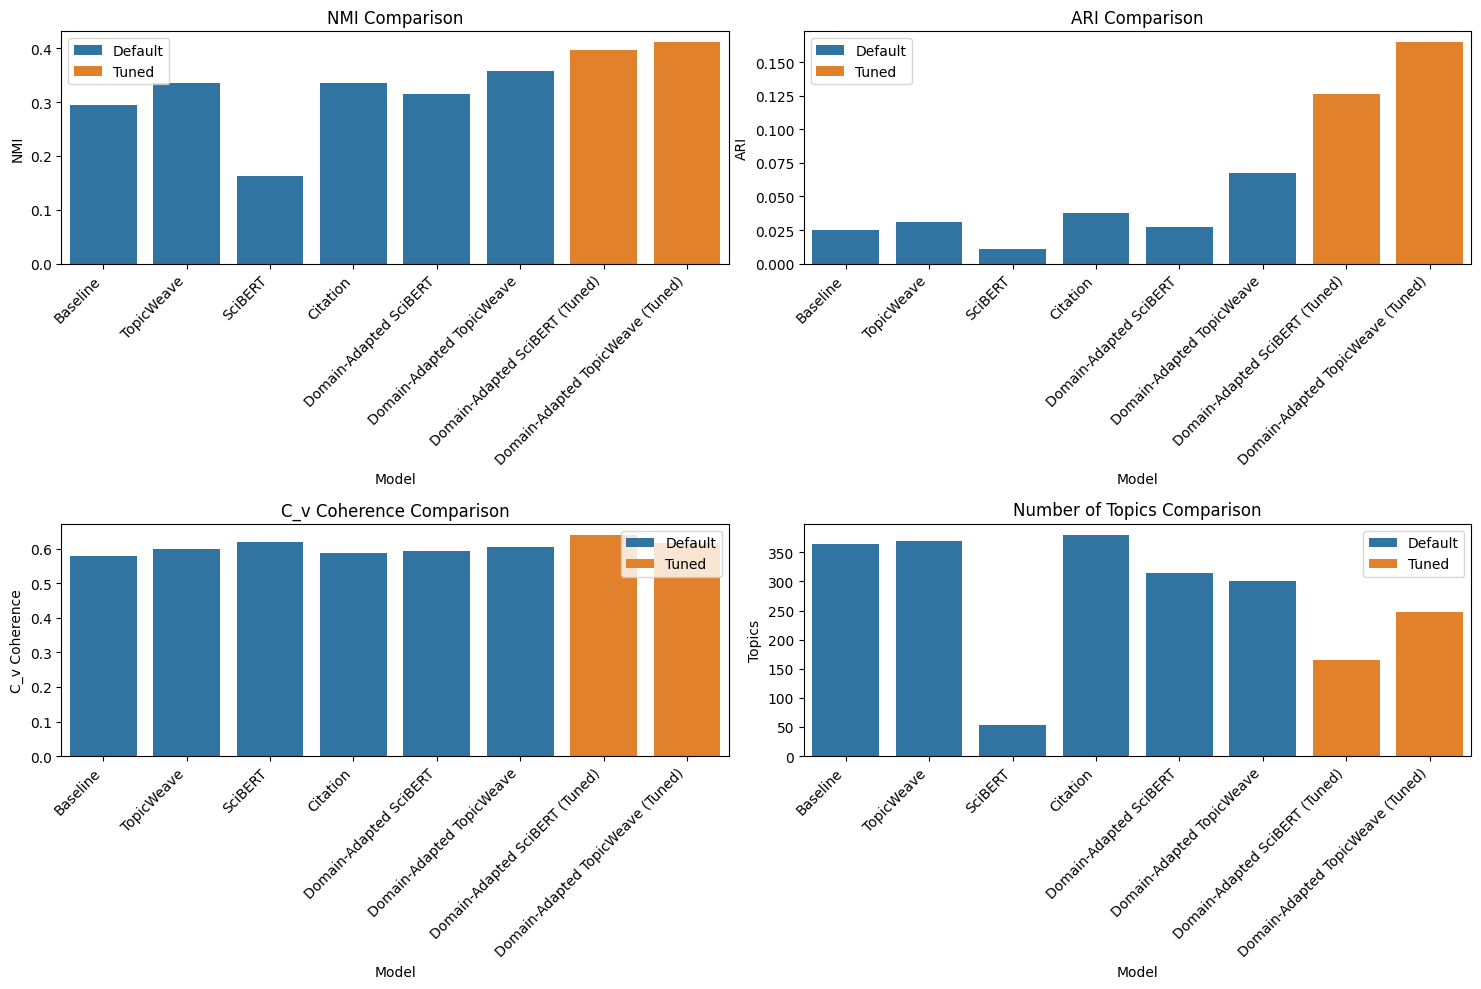

In [19]:
# Step 5: Create visualizations
print("\n[Step 5]: Creating comprehensive visualizations")
summary_df = create_comprehensive_visualizations(default_results, tuned_results)

In [20]:
# Step 6: Create domain-specific analysis
print("\n[Step 6]: Creating domain-specific analysis")
domain_df = create_domain_specific_analysis(default_results, tuned_results)


[Step 6]: Creating domain-specific analysis

===== Creating Domain-Specific Analysis =====


In [23]:
# Step 7: Save results
print("\n[Step 7]: Saving comprehensive results")
save_comprehensive_results(default_results, summary_df, domain_df, tuned_results)

end_time = datetime.now()
duration = end_time - start_time
print(f"\nTopicWeave Comprehensive Evaluation - Completed at {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Total execution time: {duration}")


[Step 7]: Saving comprehensive results

===== Saving Comprehensive Results =====
Results saved to /content/drive/MyDrive/MIDS/W266/final_project//evaluation_results/

TopicWeave Comprehensive Evaluation - Completed at 2025-03-31 04:08
Total execution time: 5:49:53.181620
